In [17]:
import sys
import os
import numpy as np
import pandas as pd

from PIL import Image
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection
from matplotlib import pyplot as plt

from tokenExtraction import TokenReader
from tableExtraction import PretrainTableExtractionPipeline

# Give priority to the modules that are inside tableTransformer 
# and handles the conflict between tableTransformer/detr/datasets and hugging face datasets' library
sys.path.insert(1, os.getcwd() + '/tableTransformer/src')
sys.path.insert(2, os.getcwd() + '/tableTransformer/detr')
# This snipet is necessary for inference to work

from tableTransformer.src.inference import output_result

from dotenv import load_dotenv
load_dotenv() 


True

In [2]:
TABLE_DETECTION_MODEL = AutoModelForObjectDetection.from_pretrained(os.environ['TABLE_DETECTION_MODEL_PATH'], revision="no_timm")
TABLE_STRUCTURE_MODEL = TableTransformerForObjectDetection.from_pretrained(os.environ['TABLE_STRUCTURE_MODEL_PATH'])

In [3]:
table_extraction_pipeline = PretrainTableExtractionPipeline(
    det_device=os.environ['TABLE_DETECTION_DEVICE'], 
    str_device=os.environ['TABLE_STRUCTURE_DEVICE'], 
    det_model=TABLE_DETECTION_MODEL,
    str_model=TABLE_STRUCTURE_MODEL
)

In [4]:
def side_by_side_plot(img1, img2): 
    f, axarr = plt.subplots(1, 2, figsize=(16,9))
    axarr[0].imshow( img1 )
    axarr[1].imshow( img2 )

    axarr[1].axis('off')
    axarr[0].axis('off')
    plt.show()

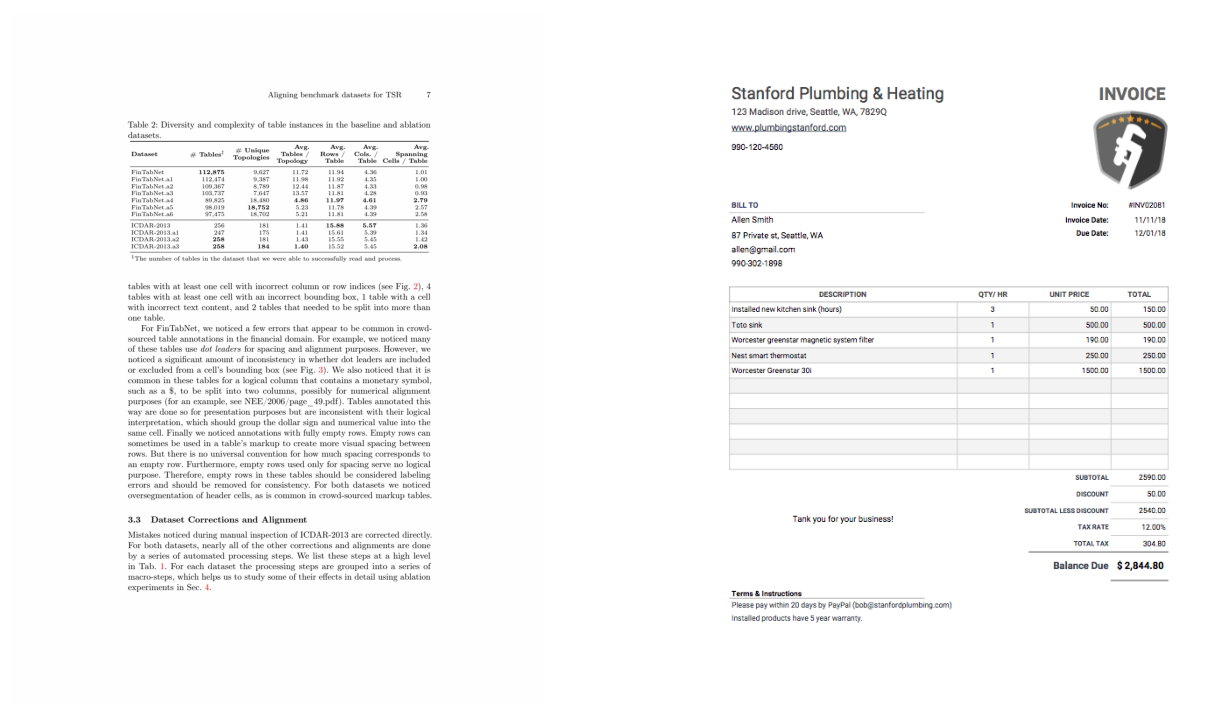

In [5]:
invoice_img_file_name = 'Sample-Invoice-printable.jpg'
paper_img_file_name = '2303_00716.jpg'

paper_image = Image.open(paper_img_file_name).convert('RGB')
invoice_image = Image.open(invoice_img_file_name).convert('RGB')

side_by_side_plot(paper_image, invoice_image)

`tokens` is expected to be a list of dictionaries containing a list of words and their bounding boxes in image coordinates. It is assumed to be sorted in reading order. The format for tokens is:  
```python
[
    {
        'bbox': [0.0, 0.0, 50.0, 50.0],
        'text': 'First'
        'span_num': 1,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    },
    {
        'bbox': [52.0, 0.0, 102.0, 50.0],
        'text': 'next'
        'span_num': 2,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    }
]
```

Multiple approaches  can be evaluated:
- **OCR the Entire Document**: This approach involves performing OCR on the whole document and subsequently passing the extracted tokens through the processing pipeline. This method is expected to be effective as the extract method reassigns tokens with the output from the previous step in the pipeline. However, this method can be computationally expensive and time-consuming, especially for large documents. On top of this, non-relevant parts of the document may introduce noise that can affect the accuracy of table extraction. 

- **OCR Cropped Tables**: By focusing the OCR process on cropped tables, the extracted tokens can be directly fed into the recognition function. This targeted approach ensures that only relevant data is processed, potentially improving both speed and accuracy.

- **OCR Individual Cells**: As demonstrated in this [tutorial by Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb), OCR can be applied to each cell individually. I will not cover this method as it presumes that tokens are obtained following the table structure extraction. However, the positional information of tokens significantly aids in structure detection, as demonstrated by the `tableTransformer.src.inference.objects_to_structures` function.


I'm using [EasyOCR](www.jaided.ai/easyocr/) to get tokens from images: 
- You can find here the documentation: http://www.jaided.ai/easyocr/documentation/   
- Here is a nice Quickstart Tutorial: https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168

Additional ressources: 
- Improve noisy image quality: https://github.com/microsoft/table-transformer/discussions/146
- Generate tokens for image and pdf: https://github.com/microsoft/table-transformer/issues/121
- Fix punctuation and missing numbers by providing `low_text=0.3` to the reader: https://stackoverflow.com/questions/77738509/easyocr-does-not-recognize-this-number-in-an-image
- Fix number recognition issues by providing mag_ratio=2: https://github.com/JaidedAI/EasyOCR/issues/254#issuecomment-1267379900


## OCR the whole document

In [36]:
token_reader = TokenReader(
    language=os.environ['READER_LANGUAGE'], 
    device=os.environ['READER_DEVICE']
)
readtext_args = {'low_text': 0.3} # 'mag_ratio': 2.0

paper_tokens = token_reader.get_tokens(paper_img_file_name, readtext_args)
invoice_tokens = token_reader.get_tokens(invoice_img_file_name, readtext_args)

Using CPU. Note: This module is much faster with a GPU.


### One step table extraction 

In [37]:
def create_folder_if_not_exist(folder_path: str):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [38]:
create_folder_if_not_exist('outputs/one_step_extraction/')
args = type('Args', (object,), {
    'visualize': True, 
    'out_dir': 'outputs/one_step_extraction/',
    'verbose': False
} )

out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

paper_extracted_tables = table_extraction_pipeline.extract(paper_image, tokens=paper_tokens, **out_options)
invoice_extracted_tables = table_extraction_pipeline.extract(invoice_image, tokens=invoice_tokens, **out_options)

In [39]:
for table_idx, extracted_table in enumerate(paper_extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], paper_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg')) 

for table_idx, extracted_table in enumerate(invoice_extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], invoice_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg'))

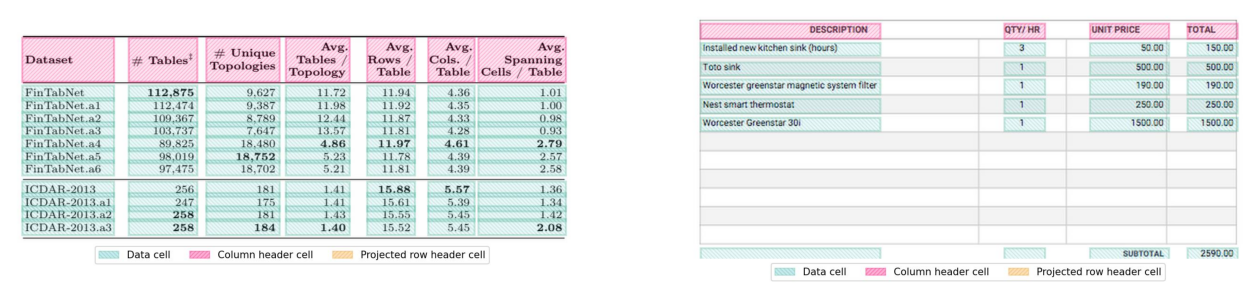

In [40]:
paper_result_one_step_fig_cells = Image.open(args.out_dir + paper_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg')).convert("RGB")
invoice_result_one_step_fig_cells = Image.open(args.out_dir + invoice_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg')).convert("RGB")

side_by_side_plot(paper_result_one_step_fig_cells, invoice_result_one_step_fig_cells)

In [41]:
pd.read_csv(args.out_dir + paper_img_file_name.replace('.jpg', '_crop_0_0.csv'))

,Dataset,# Tablest,# Unique Topologies,Tables Topology Avg:,Rows Table Avg:,Cols. Table Avg;,Spanning Cells Table Avg:
0,Fin TabNet,"112,875","9,627",11.72,11.94,4.36,1.01
1,FinTabNet.al,"112,474","9,387",11.98,11.92,4.35,1.00
2,Fin TabNel.a2,109.367,"8,789",12.44,11.87,4.33,0.98
3,Fin TabNel.a3,"103,737","7,647",13.57,11.81,4.28,0.93
4,FinTabNet.a4,"89,825","18,480",4.86,11.97,4.61,2.79
5,Fin TabNet.a5,"98,019","18,752",5.23,11.78,4.39,2.57
6,Fin TabNet.a6,"97,475","18,702",5.21,11.81,4.39,2.58
7,ICDAR-2013,256,181,1.41,15.88,5.57,1.36
8,ICDAR-2013.al,247,175,1.41,15.61,5.39,1.34
9,ICDAR-2013.a2,258,181,1.43,15.55,5.45,1.42


In [42]:
pd.read_csv(args.out_dir + invoice_img_file_name.replace('.jpg', '_crop_0_0.csv'))

,DESCRIPTIOM,QTyi HR,UNIT PRICE,Totil
0,Inste nenkitchen sink (hours),NaN,53.j0,IS0cj
1,Toto sik,NaN,SCiCO,sod.C?
2,Worcese greenster megnejic sys em filzer,NaN,153C0,190.CJ
3,Hedsmanthernoste;,NaN,251 j0,250.0J
4,Worces er Gieens er 30i,NaN,15C3.*0,1s00.CI
5,NaN,NaN,SULTOTAL,2590cj


## OCR the only the cropped tables

### Two Steps table extraction

In [43]:
detection_out_options = {
    'out_objects': True,
    'out_crops': True
}
structure_out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

create_folder_if_not_exist('outputs/two_steps_extraction/')
args = type('Args', (object,), {
    'visualize':True,
    'out_dir': 'outputs/two_steps_extraction/',
    'verbose': False
})

# paper document
paper_detected_tables = table_extraction_pipeline.detect(paper_image, **detection_out_options)

for table_idx, crop_table in enumerate(paper_detected_tables['crops']): 
    crop_image = crop_table['image']
    crop_tokens = token_reader.get_tokens(np.array(crop_image.convert('L')), readtext_args)
    
    table_structure = table_extraction_pipeline.recognize(
        crop_image, 
        crop_tokens, 
        **out_options
    )

    for key, val in table_structure.items():
        output_result(key, val, args, crop_image, paper_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg'))

# invoice document
invoice_detected_tables = table_extraction_pipeline.detect(invoice_image, **detection_out_options)

for table_idx, crop_table in enumerate(invoice_detected_tables['crops']): 
    crop_image = crop_table['image']
    crop_tokens = token_reader.get_tokens(np.array(crop_image.convert('L')), readtext_args)
    
    table_structure = table_extraction_pipeline.recognize(
        crop_image, 
        crop_tokens, 
        **out_options
    )

    for key, val in table_structure.items():
        output_result(key, val, args, crop_image, invoice_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg'))

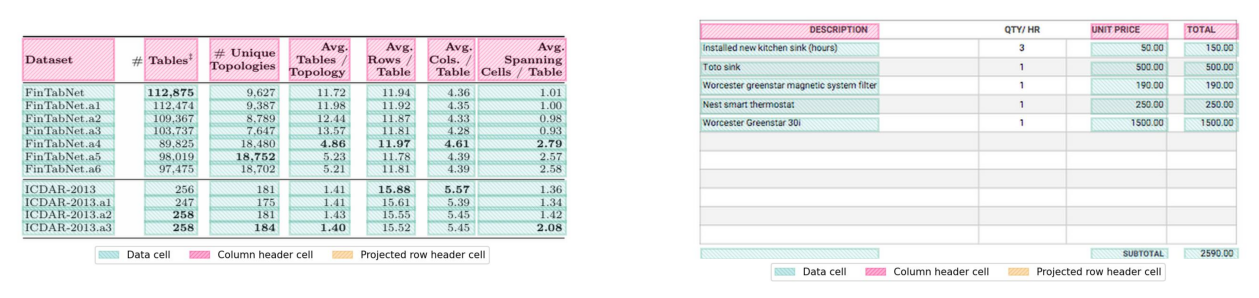

In [44]:
paper_result_two_steps_fig_cells = Image.open(args.out_dir + paper_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg')).convert("RGB")
invoice_result_two_steps_fig_cells = Image.open(args.out_dir + invoice_img_file_name.replace('.jpg', '_crop_0_fig_cells.jpg')).convert("RGB")

side_by_side_plot(paper_result_two_steps_fig_cells, invoice_result_two_steps_fig_cells)

In [45]:
pd.read_csv(args.out_dir + paper_img_file_name.replace('.jpg', '_crop_0_0.csv'))

,Dataset,Tables',# Unique Topologies,Tables Topology Avg;,Rows Table Avg;,Cols. Table Avg:,Spanning Cells Table Avg:
0,FinTabNet,"112,875","9,627",11.72,11.94,4.36,1.01
1,Fin TabNet.al,"112,474","9,387",11.98,11.92,4.35,1.00
2,FinTabNet.a2,"109,367","8,789",12.44,11.87,4.33,0.98
3,FinTabNet.a3,"103,737","7,647",13.57,11.81,4.28,0.93
4,FinTabNet.a4,"89,825","18,480",4.86,11.97,4.61,2.79
5,Fin TabNet.a5,"98,019","18,752",5.23,11.78,4.39,2.57
6,FinTabNet.a6,"97,475","18,702",5.21,11.81,4.39,2.58
7,ICDAR-2013,256,181,1.41,15.88,5.57,1.36
8,ICDAR-2013.al,247,175,1.41,15.61,5.39,1.34
9,ICDAR-2013.a2,258,181,1.43,15.55,5.45,1.42


In [46]:
pd.read_csv(args.out_dir + invoice_img_file_name.replace('.jpg', '_crop_0_0.csv'))

,DESCRIPTION,UHTT PRICE,TOTAL
0,Instelled nenkitchen sink thours),5100,Is0.C3
1,Totc sik,SCiCO,SoDCZ
2,Worces:er greenster megnejic sys em tilter,15100,190.03
3,smantheroste;,251.W0,250.0J
4,Worces:er Greens:er 301,1s03.j0,1s00.0J
5,NaN,SULTOTAL,2590CJ


The table extracted from a research paper demonstrates that the main difference between one-step and two-step extraction lies in column distribution, particularly in tight layouts. With one-step extraction, the columns are wider and tend to overlap more than in the two-step method.

However, for the tested invoice image, both extraction methods perform poorly. In the one-step approach, all columns are detected, while the two-step process misses a central column. The OCR result is inconsistent, particularly struggling to recognize digits, likely due to the poor quality of the document.